# ML: Evaluation of performance and interpretation (SHAP)

In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import lightgbm as lgb

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from glob import glob
import os
import optuna
import joblib
import json
import pickle

## Load best parameters

In [2]:
agg = 'mean'
lookback_window = 60
run_date = '2022-06-02'
thresh = 12

source_dir = f'../experiments/window-{lookback_window}-filter-{thresh}/{agg}/'
study_name = f'{agg}-window-{lookback_window}-{run_date}'
storage_path = f'sqlite:///{source_dir}/{study_name}.db'

study = optuna.load_study(study_name=study_name, storage=storage_path)
res = study.trials_dataframe(attrs=('number', 'value', 'params', 'state', 'duration'))

In [3]:
# get current best params
best_params = {}
for key, value in res.sort_values('value', ascending=True).iloc[0].to_dict().items():
    if key.startswith('params_'):
        best_params[key.replace('params_', '')] = value
    elif key == 'value':
        print("Best (RMSE) Score: ", value)
        
fixed_params = {
    'tree_learner': 'data',
    'seed':11,
    'verbose': -1,
}

lgb_params = {}
lgb_params.update(fixed_params)
lgb_params.update(best_params)

top_rate = lgb_params['top_rate']
other_rate = lgb_params['other_rate']

# corrects the top_rate/other_rate values to only sum to 1
if (top_rate + other_rate) > 1.0:
    lgb_params['other_rate'] = other_rate / (top_rate + other_rate)
    lgb_params['top_rate'] = top_rate / (top_rate + other_rate)

Best (RMSE) Score:  6.146534582023514


{'tree_learner': 'data',
 'seed': 11,
 'verbose': -1,
 'boosting_type': 'goss',
 'learning_rate': 0.03636200470913939,
 'max_bin': 259,
 'min_data_in_leaf': 212,
 'num_iterations': 777,
 'num_leaves': 184,
 'objective': 'regression',
 'other_rate': 0.026387157277162426,
 'top_rate': 0.8054386600565344}

## Load data and filter

In [4]:
featname_map = {
    'dayofweek': 'Day',
    'hour': 'Hour',
    'number_of_lanes': 'Number of Lanes',
    'speed_limit_kph': 'Speed Limit',
    'pix_business_4x4' : 'Nearby Commercial',
    'pix_residential_4x4': 'Nearby Residential', 
    'pix_industrial_4x4' : 'Nearby Industrial',
    'pix_institutional_4x4' : 'Nearby Institutional',
    'elevation' : 'Elevation',
}

In [5]:
data_dir = f'../datasets/inference/window-{lookback_window}-filter-{thresh}'

# load data
test = pd.read_csv(f'{data_dir}/{agg}-window-{lookback_window}-test-{run_date}.csv')
retrain = pd.read_csv(f'{data_dir}/{agg}-window-{lookback_window}-retrain-{run_date}.csv')

In [6]:
print("Retrain shape: ", retrain.shape)
print("Test shape: ", test.shape)

Retrain shape:  (1067001, 43)
Test shape:  (266751, 43)


In [7]:
# usecols for ML
discrete_num_cols = ['number_of_lanes', 'speed_limit_kph',]
building_types = ['residential', 'business', 'industrial', 'institutional']
pixel_size = '4x4'
landuse_cols = [f'pix_{type_}_{pixel_size}' for type_ in building_types]
num_cols = landuse_cols + discrete_num_cols + ['elevation']

# cat cols
cat_cols = ['hour', 'dayofweek']
features = sorted(cat_cols + num_cols) # sort for reference in feature order
cat_cols_index = [index for (index, col) in enumerate(features) if col in cat_cols]
cat_cols_index

[0, 2]

In [8]:
results_dir = f"../results/window-{lookback_window}-filter-{thresh}"
column_labels_dir = "column-labels"
save_dir = os.path.join(results_dir, column_labels_dir)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# write feature order to file as reference
with open(f'{save_dir}/{study_name}-columnrefs.pickle', 'wb') as f:
    pickle.dump(features, f)

In [9]:
# use recomputed_speed
X_train, y_train = retrain[features], retrain['agg_speed']
X_test, y_test = test[features], test['agg_speed']

In [11]:
%%time
model = lgb.LGBMRegressor(**lgb_params)
model.fit(X_train, y_train, categorical_feature=cat_cols_index)

Found `num_iterations` in params. Will use it instead of argument
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=212, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=212
CPU times: user 36min 52s, sys: 4min 21s, total: 41min 14s
Wall time: 2min 10s


LGBMRegressor(boosting_type='goss', learning_rate=0.03636200470913939,
              max_bin=259, min_data_in_leaf=212, num_iterations=777,
              num_leaves=184, objective='regression',
              other_rate=0.026387157277162426, seed=11,
              top_rate=0.8054386600565344, tree_learner='data', verbose=-1)

In [12]:
# save model
save_dir = os.path.join(results_dir, 'models')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
model.booster_.save_model(f'{save_dir}/{study_name}-model.txt')

In [13]:
# save y-yhat
y_pred = model.predict(X_test)
y_true = y_test.values

y_yhat = {
    'true': list(y_true),
    'pred' : list(y_pred)
}

save_dir = os.path.join(results_dir, 'predictions')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
with open(f'{save_dir}/{study_name}-preds.json', 'w') as f:
    json.dump(y_yhat, f)

In [14]:
def get_score(y_true, y_preds):
    return r2_score(y_true, y_preds)
def rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

print("R2: ", get_score(y_true, y_pred))
print("RMSE: ", rmse(y_true, y_pred))
print("MAE: ", mean_absolute_error(y_true, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_true, y_pred))
# MAPE spikes because of y_true having values of zero, because of the division by epsilon

R2:  0.7450283035400903
RMSE:  5.8534671174952
MAE:  4.418770002831804
MAPE:  141252944419431.56


In [15]:
def plot_lgb_yyhat(y_true, y_pred, title, ax):
    temp = pd.DataFrame()
    temp['True Value'] = y_true
    temp['Predicted Value'] = y_pred
    temp.plot(kind='scatter', x='True Value', y='Predicted Value',
              ax=ax, alpha=0.1, c='green', marker='*')
    
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('True Value', fontsize=12)
    ax.set_ylabel('Predicted Value', fontsize=12)

    ax.set_ylim([i for i in ax.get_xlim()])
    
    # diagonal perfect prediction reference
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, c='black',
                   label='Perfect Prediction')
    ax.legend(fontsize=15, loc='upper left')
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # set spines lw
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    
    # tick params
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
    r2 = get_score(y_true, y_pred)
    ax.annotate(f"R2={r2:.2f}", size=15, xy=(55, 0))
    
    rmse_score = rmse(y_true, y_pred)
    ax.annotate(f"RMSE={rmse_score:.2f}", size=15, xy=(55, 5))
    return ax

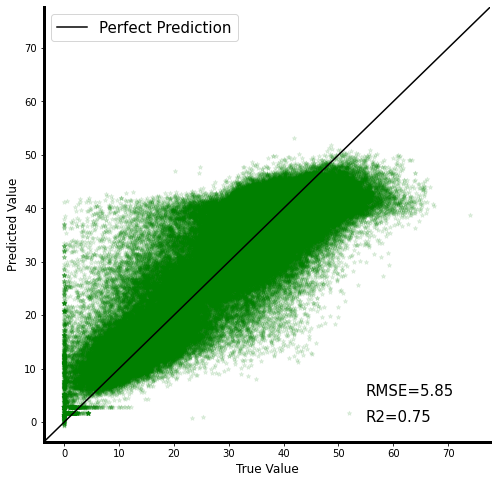

In [16]:
figures_dir = f'../figures/window-{lookback_window}-filter-{thresh}'
save_dir = os.path.join(figures_dir, 'performance')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
fig, ax = plt.subplots(figsize=(8, 8))
plot_lgb_yyhat(y_true, y_pred, title=None, ax=ax)
    
fig.savefig(f'{save_dir}/{study_name}-yyhat.jpg', dpi=600, bbox_inches='tight')
plt.show()

## SHAP Evaluation

In [17]:
X_test = X_test.rename(columns=featname_map)

In [18]:
%%time
print("Test set shape: ", X_test.shape)

# perfrom shap on test set
explainer = shap.TreeExplainer(model)

Test set shape:  (266751, 9)
CPU times: user 10.2 s, sys: 419 ms, total: 10.6 s
Wall time: 11.6 s


In [19]:
%%time
explanation = explainer(X_test)

CPU times: user 6h 41min 21s, sys: 33 s, total: 6h 41min 54s
Wall time: 24min 41s


In [20]:
%%time
# shap_values = explainer.shap_valus(X_test.sample(n=1000, replace=False)) # change to X_test
shap_values = explainer.shap_values(X_test) 

CPU times: user 6h 41min 14s, sys: 32.8 s, total: 6h 41min 47s
Wall time: 23min 50s


In [21]:
save_dir = os.path.join(results_dir, 'shap-vals')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

with open(f'{save_dir}/{study_name}-shap-vals.pickle', 'wb') as f:
    pickle.dump(shap_values, f)

### Global Interpretations

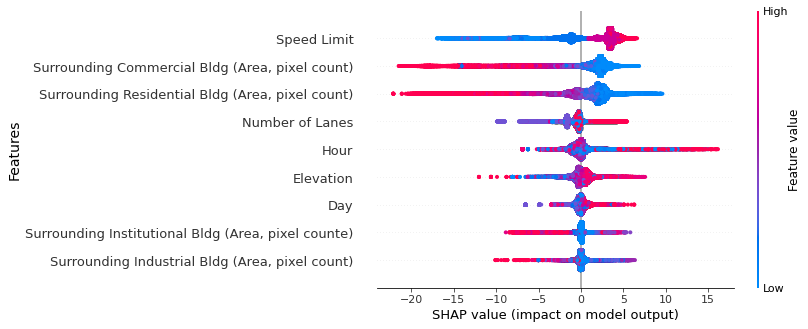

CPU times: user 1min 20s, sys: 655 ms, total: 1min 21s
Wall time: 1min 24s


In [22]:
%%time
# plots beeswarm
sum_fig = shap.summary_plot(shap_values, X_test, show=False)

# plt.title('Summary Plot of SHAP Importance', fontsize=18)
plt.ylabel('Features', fontsize=14)

## in case column names are not good for plotting use a name mapper
# ax = plt.gca()
# new_labels = [featname_map[i.get_text()] for i in ax.get_yticklabels()]
# ax.set_yticklabels(new_labels)

plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

figures_dir = f'../figures/window-{lookback_window}-filter-{thresh}'
save_dir = os.path.join(figures_dir, 'shap')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

plt.savefig(f'{save_dir}/{study_name}-beeswarm.jpg', dpi=600, bbox_inches='tight')
plt.show()

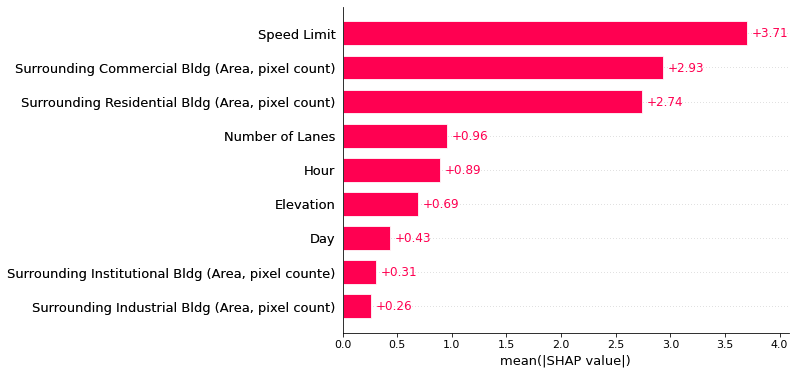

In [23]:
fi_fig = shap.plots.bar(explanation, max_display=X_test.shape[1], show=False)
# plt.title('Average SHAP Importance', fontsize=12)
# plt.ylabel('Features', fontsize=14)


## in case column names are not good for plotting use a name mapper
# ax = plt.gca()
# new_labels = [featname_map[i.get_text()] for i in ax.get_yticklabels()]
# ax.set_yticklabels(new_labels)

## black bars
# for bar in ax.containers:
#     # plt.setp sets a property on all elements of the container
#     plt.setp(bar, color="black")



# Hide the right and top spines
ax.spines['left'].set_visible(False)

plt.savefig(f'{save_dir}/{study_name}-fi.jpg', dpi=600, bbox_inches='tight')
plt.show()

### Local Interpretations

#### Waterfall and forceplots plots

In [24]:
# get a low error prediction for a predicted vehicle moving average speed
speed = 0 # speed of interest
speed_indexes = np.where(y_true==speed)[0]
speed_errors = (np.abs(y_true - y_pred))[y_true==speed]
sorted_indexed_errors = sorted(list(zip(speed_indexes, speed_errors)), key=lambda x:x[1])

# index of best predicted zero speed
print("Absolute Error: ", sorted_indexed_errors[0][1])
index = sorted_indexed_errors[0][0]

Absolute Error:  0.0020530586824521807


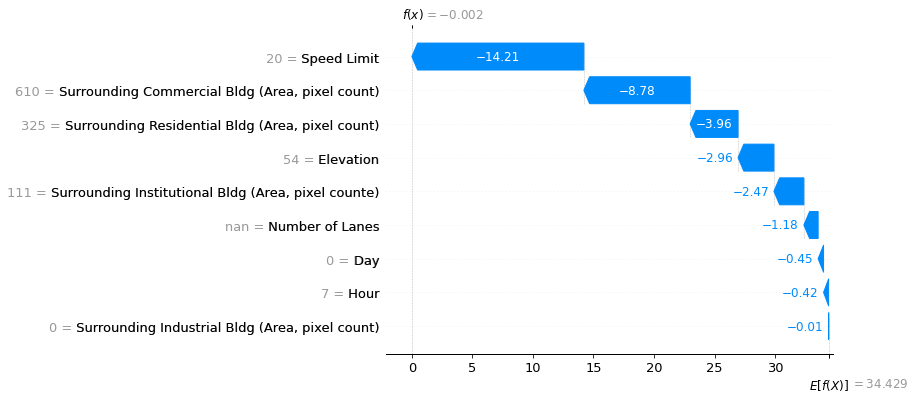

<Figure size 432x288 with 0 Axes>

In [25]:
# bar plots are used since waterfall source code has some bugs: pl.ioff() plt not found
# wf_fig = shap.waterfall_plot(explanation[index], show=False)
wf_fig = shap.waterfall_plot(explanation[index])

plt.savefig(f'{save_dir}/{study_name}-waterfall-speed-{speed}.jpg', 
            dpi=600, bbox_inches='tight')
plt.show()

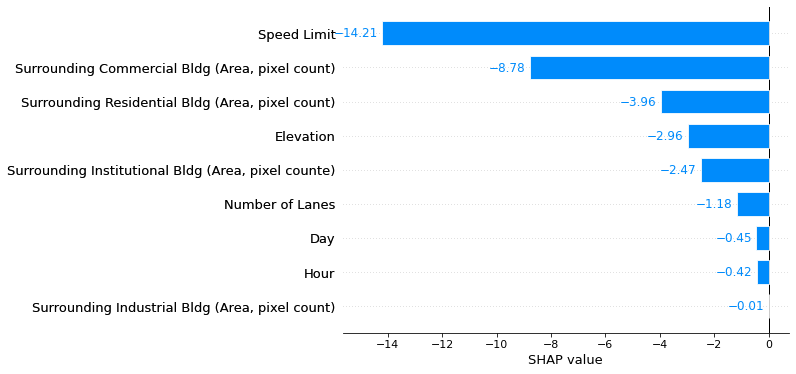

In [26]:
bar_fig = shap.plots.bar(explanation[index], show=False)

plt.savefig(f'{save_dir}/{study_name}-localbar-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
plt.show()

In [27]:
def force_plot(explainer, shap_values, X_test, j, speed):
    shap.initjs() 
    p = shap.force_plot(
        explainer.expected_value, 
        shap_values[j], X_test.iloc[[j]], 
        show=False
    )
    plt.savefig(f'{save_dir}/{study_name}-force-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
    plt.close()
    return(p)

In [28]:
force_plot(explainer, shap_values, X_test, j=index, speed=speed)

In [29]:
# get a low error prediction for a predicted vehicle moving average speed
speed = 10 # speed of interest
speed_indexes = np.where(y_true==speed)[0]
speed_errors = (np.abs(y_true - y_pred))[y_true==speed]
sorted_indexed_errors = sorted(list(zip(speed_indexes, speed_errors)), key=lambda x:x[1])

# index of best predicted zero speed
print("Absolute Error: ", sorted_indexed_errors[0][1])
index = sorted_indexed_errors[0][0]

Absolute Error:  0.043442966016618456


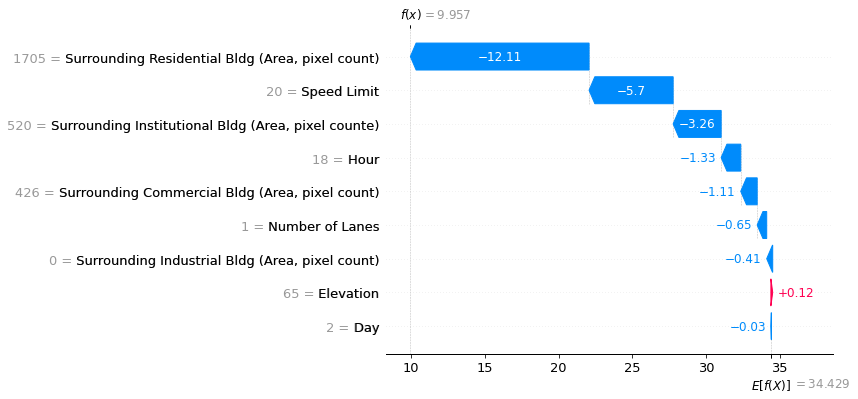

<Figure size 432x288 with 0 Axes>

In [30]:
# bar plots are used since waterfall source code has some bugs: pl.ioff() plt not found
# wf_fig = shap.waterfall_plot(explanation[index], show=False)
wf_fig = shap.waterfall_plot(explanation[index])

plt.savefig(f'{save_dir}/{study_name}-waterfall-speed-{speed}.jpg', 
            dpi=600, bbox_inches='tight')
plt.show()

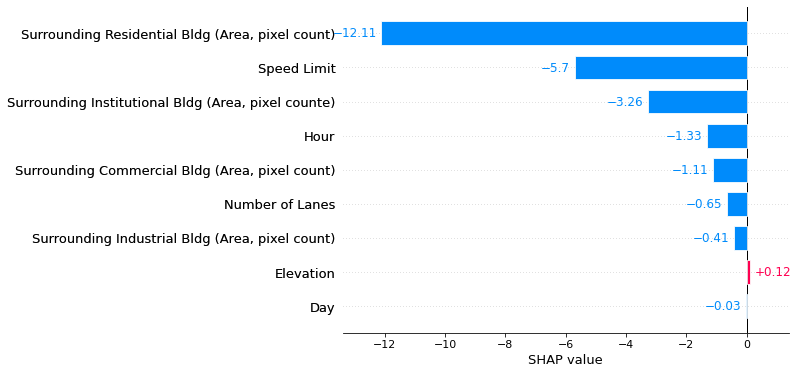

In [31]:
bar_fig = shap.plots.bar(explanation[index], show=False)

plt.savefig(f'{save_dir}/{study_name}-localbar-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
plt.show()

In [32]:
force_plot(explainer, shap_values, X_test, j=index, speed=speed)

Absolute Error:  0.15979671426302744


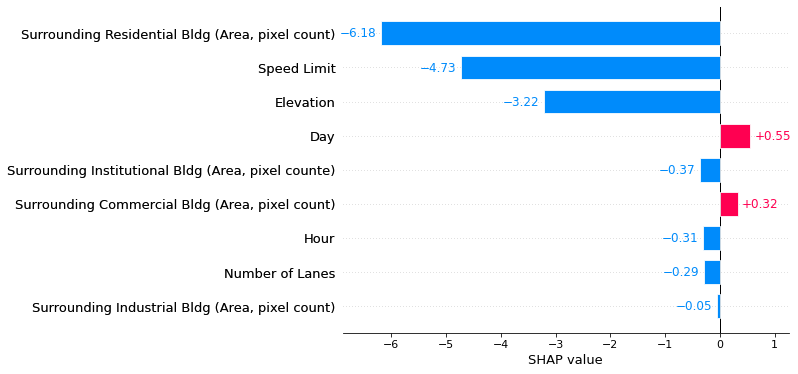

In [33]:
# get a low error prediction for a predicted vehicle moving average speed
speed = 20 # speed of interest
speed_indexes = np.where(y_true==speed)[0]
speed_errors = (np.abs(y_true - y_pred))[y_true==speed]
sorted_indexed_errors = sorted(list(zip(speed_indexes, speed_errors)), key=lambda x:x[1])

# index of best predicted zero speed
print("Absolute Error: ", sorted_indexed_errors[0][1])
index = sorted_indexed_errors[0][0]

bar_fig = shap.plots.bar(explanation[index], show=False)

plt.savefig(f'{save_dir}/{study_name}-localbar-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
plt.show()

Absolute Error:  0.006858417849851861


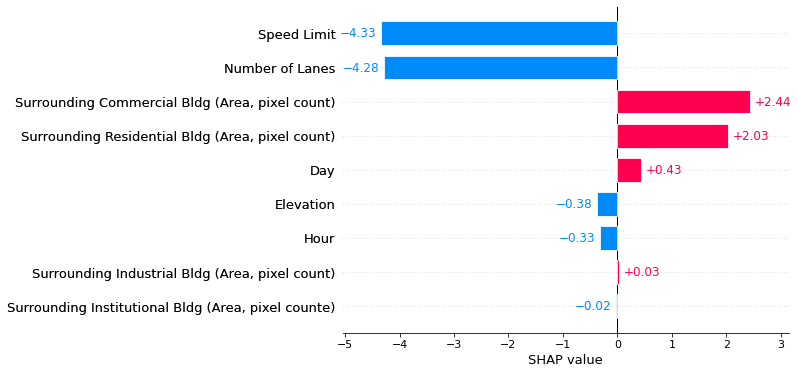

In [34]:
# get a low error prediction for a predicted vehicle moving average speed
speed = 30 # speed of interest
speed_indexes = np.where(y_true==speed)[0]
speed_errors = (np.abs(y_true - y_pred))[y_true==speed]
sorted_indexed_errors = sorted(list(zip(speed_indexes, speed_errors)), key=lambda x:x[1])

# index of best predicted zero speed
print("Absolute Error: ", sorted_indexed_errors[0][1])
index = sorted_indexed_errors[0][0]

bar_fig = shap.plots.bar(explanation[index], show=False)

plt.savefig(f'{save_dir}/{study_name}-localbar-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
plt.show()

Absolute Error:  0.001450936763809807


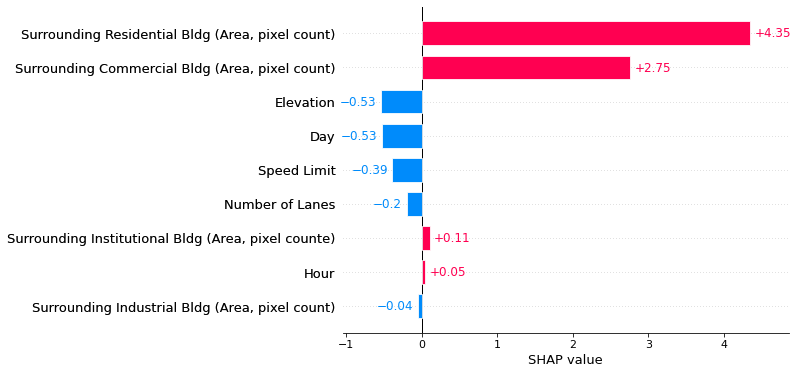

In [35]:
# get a low error prediction for a predicted vehicle moving average speed
speed = 40 # speed of interest
speed_indexes = np.where(y_true==speed)[0]
speed_errors = (np.abs(y_true - y_pred))[y_true==speed]
sorted_indexed_errors = sorted(list(zip(speed_indexes, speed_errors)), key=lambda x:x[1])

# index of best predicted zero speed
print("Absolute Error: ", sorted_indexed_errors[0][1])
index = sorted_indexed_errors[0][0]

bar_fig = shap.plots.bar(explanation[index], show=False)

plt.savefig(f'{save_dir}/{study_name}-localbar-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
plt.show()

Absolute Error:  1.7721005664672873


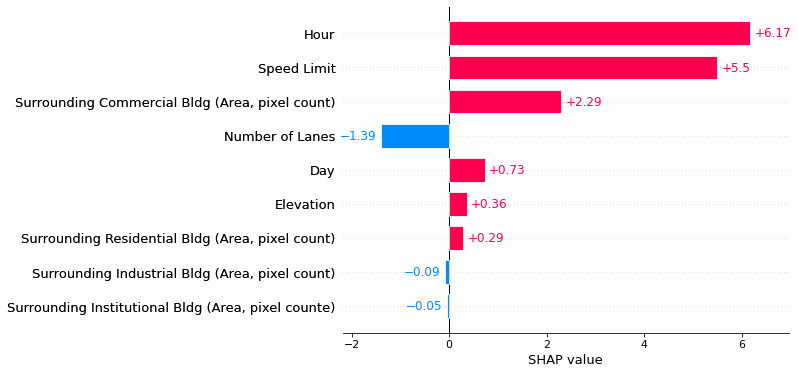

In [36]:
# get a low error prediction for a predicted vehicle moving average speed
speed = 50 # speed of interest
speed_indexes = np.where(y_true==speed)[0]
speed_errors = (np.abs(y_true - y_pred))[y_true==speed]
sorted_indexed_errors = sorted(list(zip(speed_indexes, speed_errors)), key=lambda x:x[1])

# index of best predicted zero speed
print("Absolute Error: ", sorted_indexed_errors[0][1])
index = sorted_indexed_errors[0][0]

bar_fig = shap.plots.bar(explanation[index], show=False)

plt.savefig(f'{save_dir}/{study_name}-localbar-speed-{speed}.jpg', dpi=600, bbox_inches='tight')
plt.show()

# End